In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
#from imutils import paths
#import cv2

# Data preprocessing

In [2]:
image_paths = r"C:\Users\mimii\Downloads\data"
dataset  = ["with_mask", "without_mask"]

In [3]:
training_data =[]
labels=[]
def data_preprocessing():
    for i in dataset :
        path = os.path.join(image_paths, i)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            training_data.append(image)
            labels.append(i)

In [4]:
data_preprocessing()

In [5]:
training_data=np.array(training_data,dtype='float32') 
labels=np.array(labels)

In [6]:
lb=LabelBinarizer() 
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [7]:
#split data into test data en train data 
train_X,test_X,train_Y,test_Y=train_test_split(training_data,labels,test_size=0.30,stratify=labels,random_state=20)
print (len(train_X))
print (len(test_Y))

963
413


# Training face mask detector 

In [8]:
#ImageDataGenerator to expand the dataset
data=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [9]:
#building neural network using mobileNetV2 and 5 layers  
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))
baseModel.summary()



Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

In [10]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(64,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)
model=Model(inputs=baseModel.input,outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [11]:
for layer in baseModel.layers:
    layer.trainable=False

learning_rate= 0.001
Epochs= 20
Batch_size= 32
print (len(train_X)//Batch_size)
optimizer=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

H = model.fit(data.flow(train_X,train_Y,Batch_size), steps_per_epoch=len(train_X)//Batch_size, validation_data=(test_X,test_Y), validation_steps=len(test_X)//Batch_size, epochs=Epochs)

30


C:\Users\mimii\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
30/30 [==============================] - 29s 870ms/step - loss: 0.3596 - accuracy: 0.8647 - val_loss: 0.0655 - val_accuracy: 0.9855
Epoch 2/20
30/30 [==============================] - 25s 851ms/step - loss: 0.1239 - accuracy: 0.9624 - val_loss: 0.0272 - val_accuracy: 0.9903
Epoch 3/20
30/30 [==============================] - 25s 844ms/step - loss: 0.0724 - accuracy: 0.9774 - val_loss: 0.0224 - val_accuracy: 0.9879
Epoch 4/20
30/30 [==============================] - 24s 816ms/step - loss: 0.0504 - accuracy: 0.9860 - val_loss: 0.0153 - val_accuracy: 0.9976
Epoch 5/20
30/30 [==============================] - 25s 819ms/step - loss: 0.0582 - accuracy: 0.9828 - val_loss: 0.0183 - val_accuracy: 0.9976
Epoch 6/20
30/30 [==============================] - 26s 872ms/step - loss: 0.0508 - accuracy: 0.9839 - val_loss: 0.0152 - val_accuracy: 0.9976
Epoch 7/20
30/30 [==============================] - 26s 864ms/step - loss: 0.0487 - accuracy: 0.9882 - val_loss: 0.0114 - val_accuracy: 0.9976

In [16]:
model.save("face_mask_detector_model" , save_format = "h5")

# testing face mask detector

In [17]:
#evaluate the model
test_loss, test_acc = model.evaluate(test_X,  test_Y, verbose=2)

13/13 - 6s - loss: 0.0070 - accuracy: 0.9976 - 6s/epoch - 429ms/step


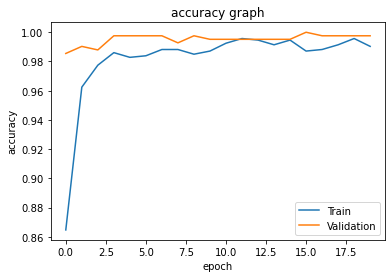

In [18]:
# plotting accuracy and validation accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('accuracy graph')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

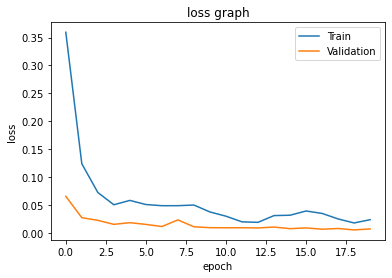

In [19]:
# plotting loss and validation loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('loss graph')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()